In [1]:
# -*- coding: utf-8 -*-
import cv2
import os
import sys
sys.path.insert(0,"/world/data-gpu-112/liliang/pytorch-reid")
import random
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import ipdb


In [2]:
def softmax(x):
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x 

def _get_pred(model, json_path, task_index):
    pred_logits = []
    pred_labels = []
    images_lst = []
    record_dict_ori = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0, "10":0, "11":0}
    label_set = set()

    with open(json_path, "r") as f:
        for line in f:
            if len(line) < 40:
                continue
#             if len(pred_labels)>batch_size:
#                 break
            path, info = line.split("\t")
            info = json.loads(info)
            label = info["label"]
            if label in label_set:
                continue
            else:
                label_set.add(label)
            image = cv2.imread(path)
            image = cv2.resize(image, (128,256)) 
            image = np.expand_dims(image, axis=0)
            images_lst.append(image)
            logits = model.predict(image)
#             import ipdb
#             ipdb.set_trace()
            logits = logits[task_index]
            logits = softmax(np.asarray(logits))[0]
            pred_label = np.argmax(logits)
            pred_labels.append(pred_label) # imshow展示原来的label
            
            record_dict_ori[str(pred_label)] += 1     
            pred_logits.append([round(i,2) for i in logits])
            
    return images_lst, pred_logits, pred_labels, record_dict_ori

def run_eval(task_index):
    from auto_deploy.predictor import Predictor
    preprocess_dict = {"norm_lambda": "lambda x: x", "color_mode": "None"}
    print ("model restored form: %s" %pretrain_snapshot)
    model = Predictor(gpu=0, input_size=(128, 256), model_path=pretrain_snapshot,
                      preprocess_dict=preprocess_dict)
    
    # forward
    imgs, pred_logits, pred_labels, record_dict_ori = _get_pred(model, json_path, task_index)
    
    return imgs, pred_logits, pred_labels, record_dict_ori

In [46]:
# plt config
h_gap = 50
v_gap = 50
text_gap = 45
rows = 8
cols = 7
num_samples = rows*cols
img_size = (256, 128)
page = np.ones(((img_size[0]+h_gap)*rows, (img_size[1]+v_gap)*cols, 3), dtype=np.uint8) * 255

# pretrain_snapshot = "/world/data-c7/xiaoyouchang/resnet_50_ibn_a_20190409_163335.pt"
pretrain_snapshot = "/world/data-gpu-112/liliang/pytorch-output-mt/v5final_1.5tw-all1/resnet_50_ibn_a_20190920_093954.pt"
# pretrain_snapshot = "/world/data-gpu-112/liliang/pytorch-output-mt/v5++_resnet50_age_552_o10_s0.7_var1.2/resnet_50_ibn_a_20190905_200947.pt"

json_path = "/world/data-c26/liliang/anta_json/lehuameilan_new.json"
dataset_name = json_path.split("/")[-1].split(".")[0]
batch_size = num_samples
task_idx = {"age":1, "bag":2, "gender":3, "orient":4}
age_scpoe_mapping = {0:"0-1", 1:"2-5", 2:"6-10", 3:"11-15", 4:"16-20", 
                    5:"21-25", 6:"26-30", 7:"31-40", 8:"41-50", 
                     9:"51-60", 10:"61-80", 11:"80+", }

# imgs to np.ndarray
imgs, pred_logits, pred_labels, record_dict_ori = run_eval(task_idx["age"])


model restored form: /world/data-gpu-112/liliang/pytorch-output-mt/v5final_1.5tw-all1/resnet_50_ibn_a_20190920_093954.pt


KeyboardInterrupt: 

distribution: {'0-1': 0, '2-5': 4, '6-10': 43, '11-15': 446, '16-20': 630, '21-25': 348, '26-30': 115, '31-40': 145, '41-50': 148, '51-60': 81, '61-80': 57, '80+': 0}
distribution: {'0-1': 0, '2-5': 4, '6-10': 43, '11-15': 446, '16-20': 630, '21-25': 174, '26-30': 117, '31-40': 218, '41-50': 247, '51-60': 81, '61-80': 57, '80+': 0}
total ids: 2017


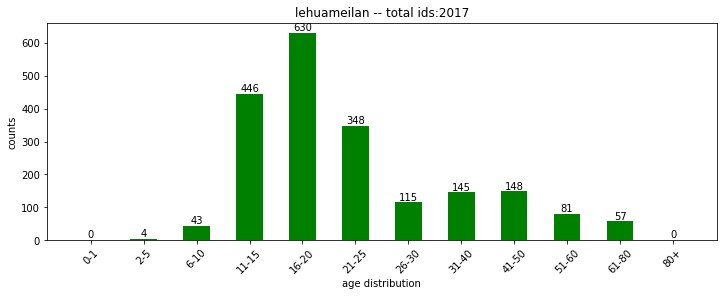

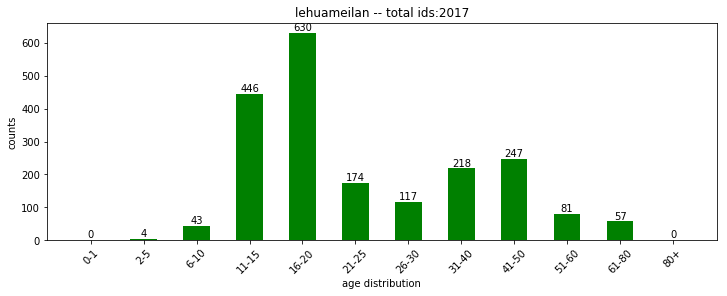

/usr/local/python-3.6.5/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


375


375

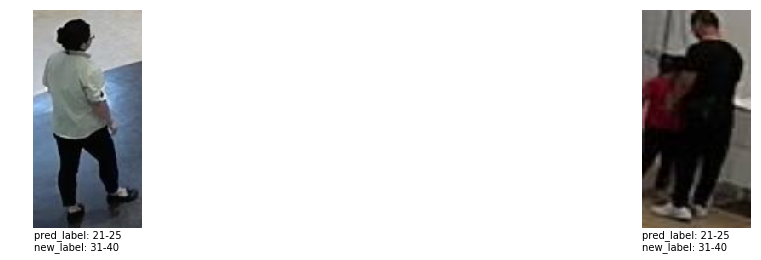

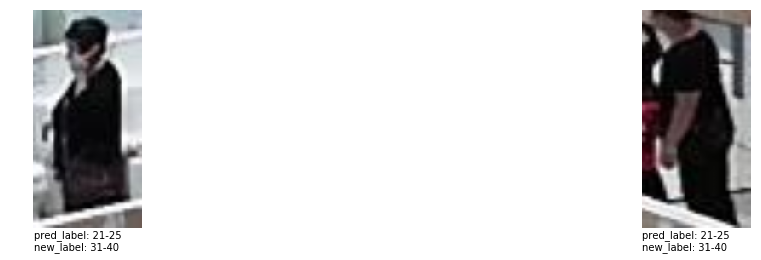

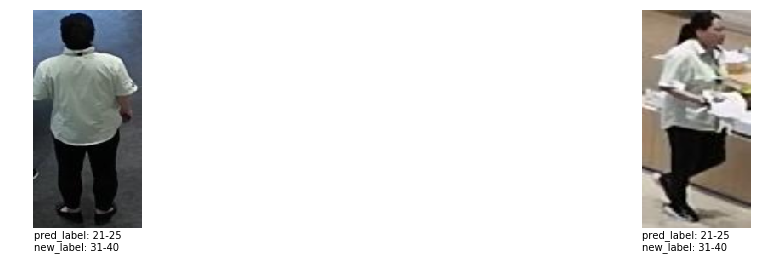

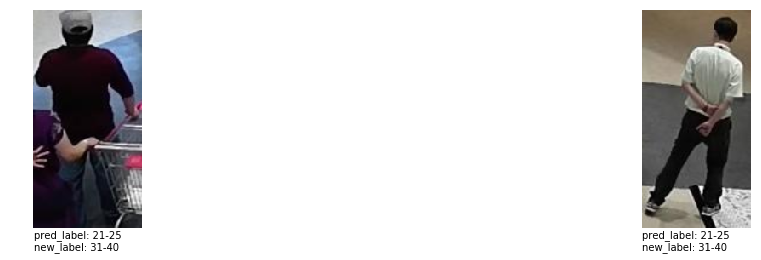

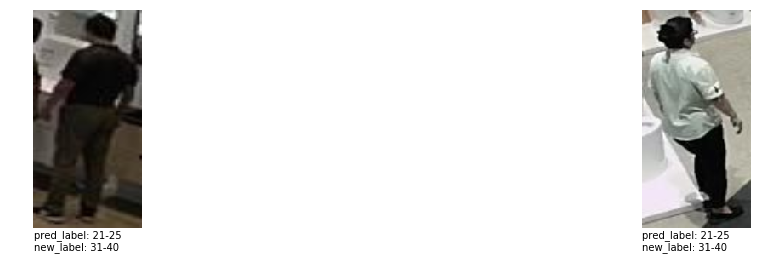

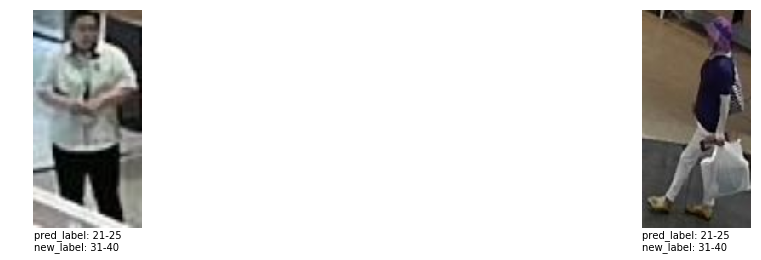

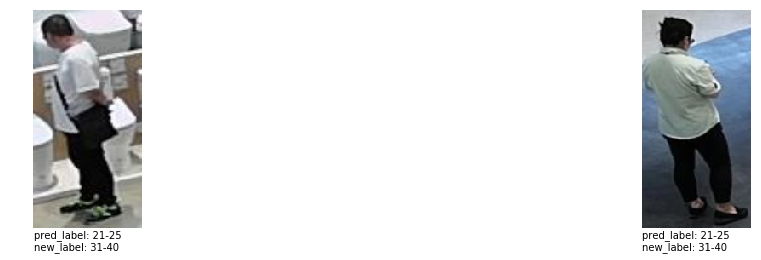

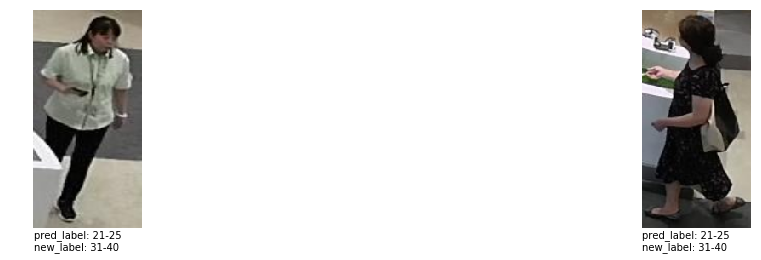

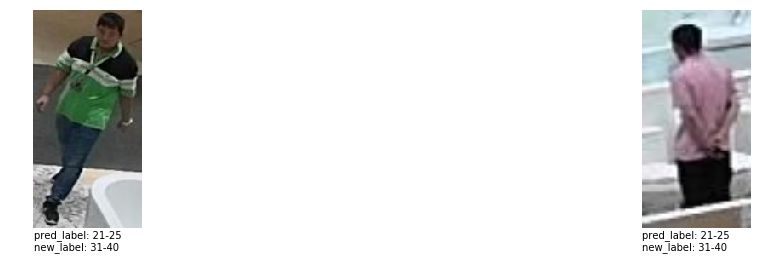

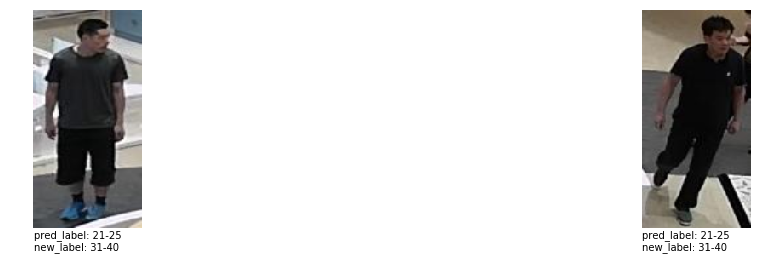

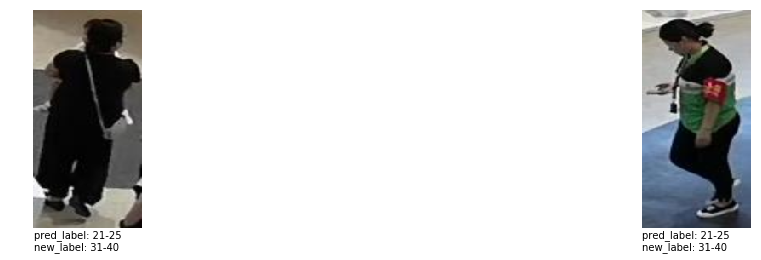

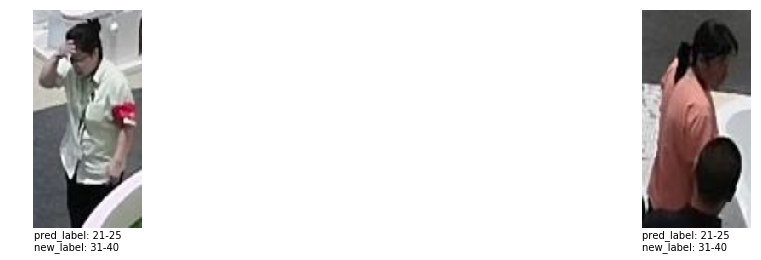

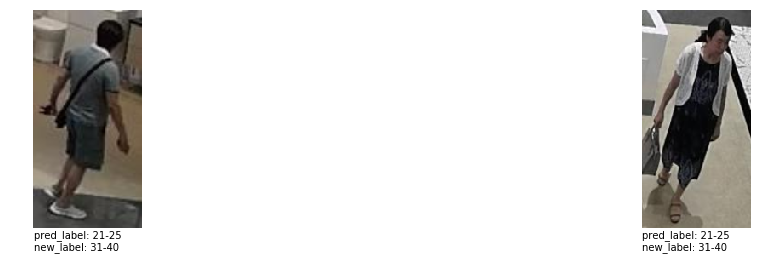

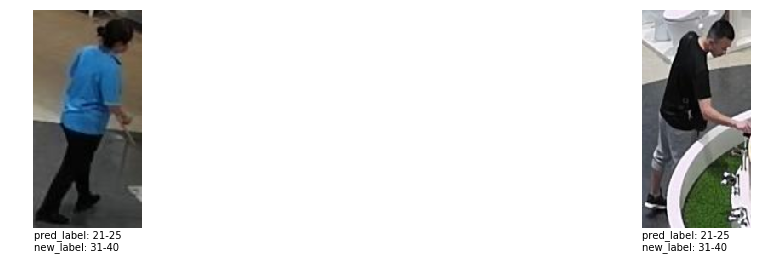

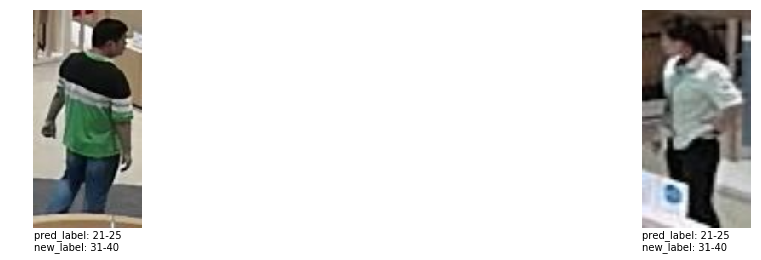

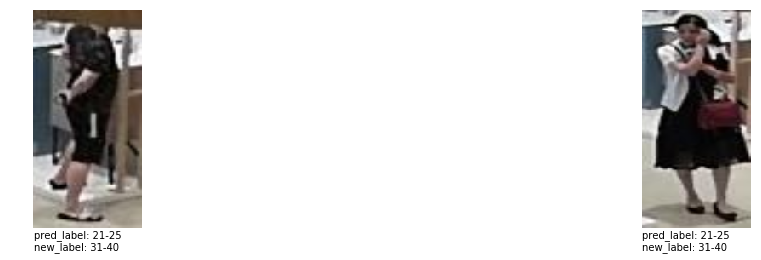

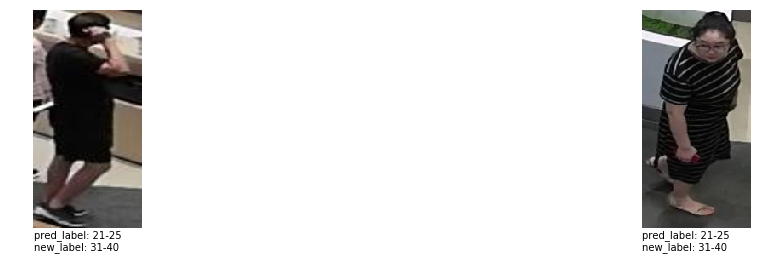

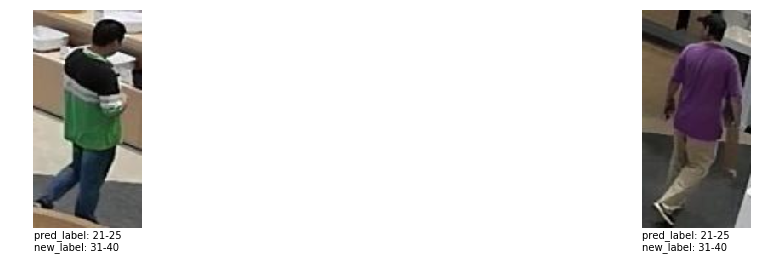

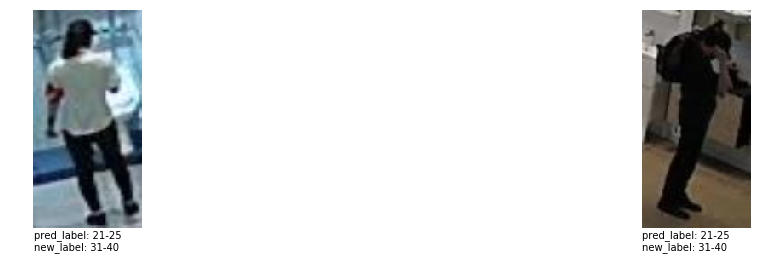

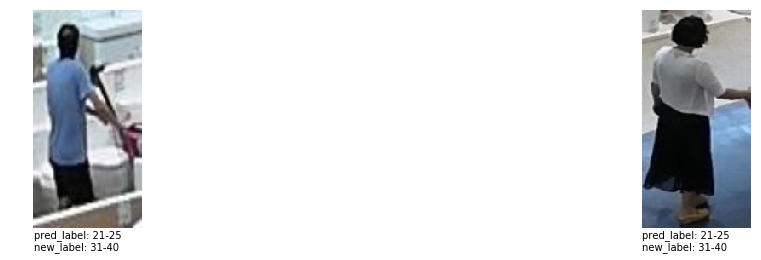

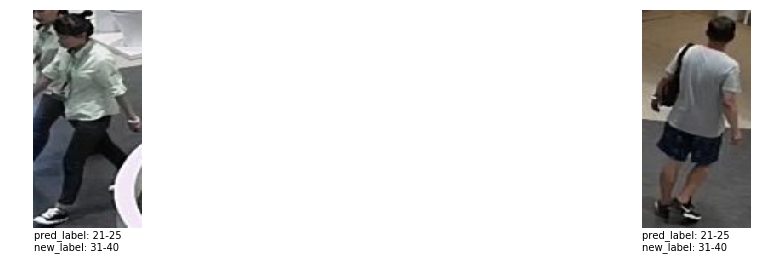

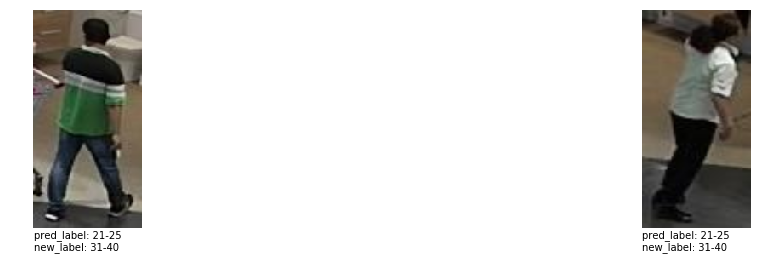

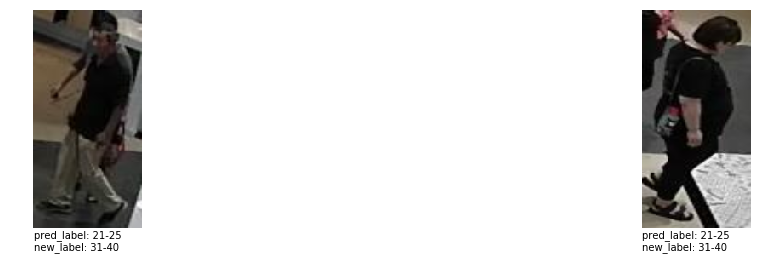

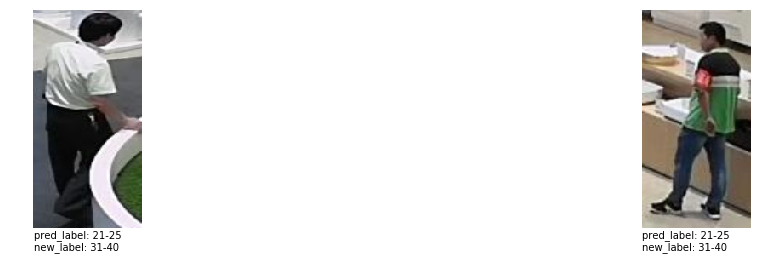

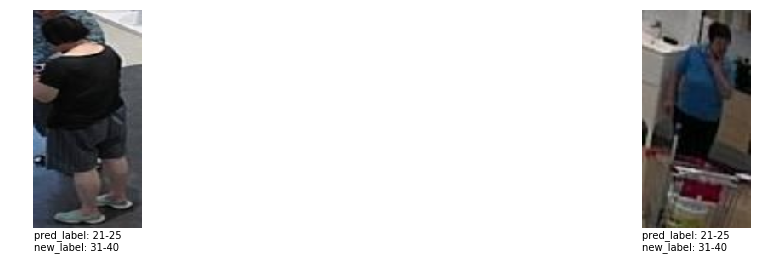

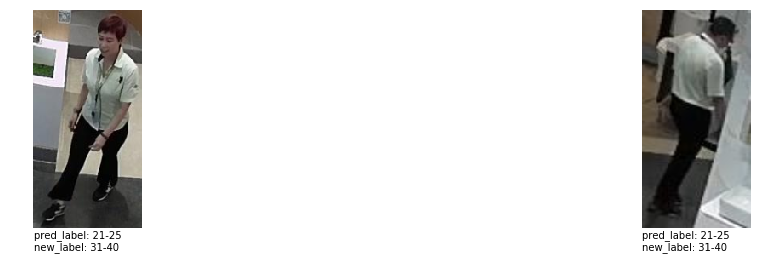

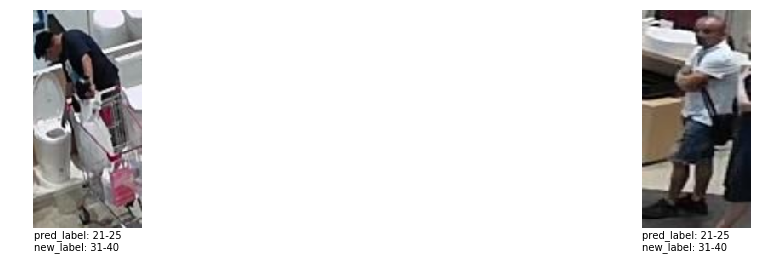

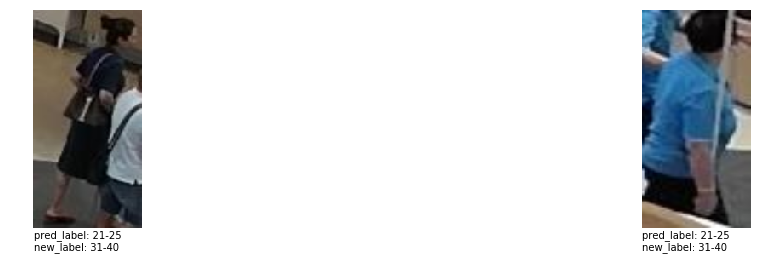

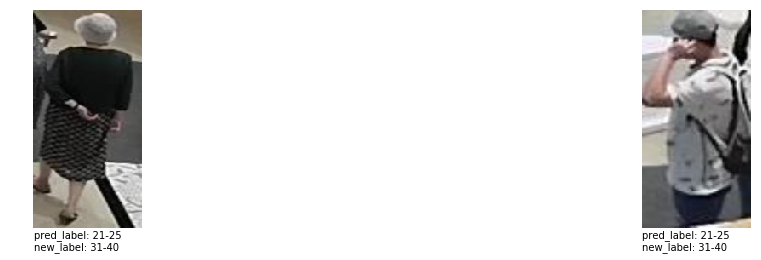

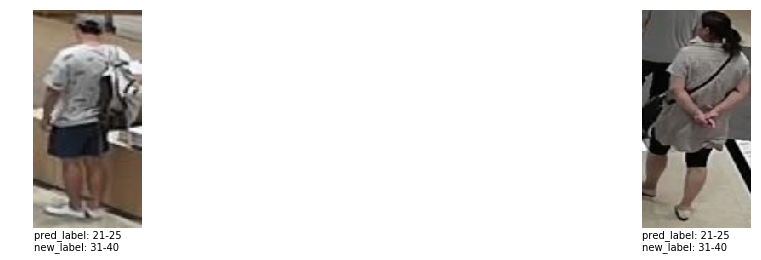

In [44]:
def get_scope(record_dict):
    label_lst = []
    scope = ["0-1", "2-5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-40", "41-50", "51-60", "61-80", "80+"]
    scope_cnt = list(record_dict.values())
    print("distribution: %s"%dict(zip(scope, scope_cnt)))
    return scope, scope_cnt

def label_reassign(pred_logits, pred_labels):
    chg_flag = []
    record_dict_chg = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0, "10":0, "11":0}
    show_logits = []
    new_labels = []
    for i in range(len(pred_logits)):
        pred_label = pred_labels[i]
        logits = pred_logits[i]
        if pred_label == 6 and logits[7]>=0.1:
            chg_label = 7
            chg_flag.append(True) # 标记 26-30转换为31-40 
        elif  pred_label == 5 and logits[7]>=0.1:
            chg_label = 7
            chg_flag.append(True) # 标记 21-25转换为31-40 
        elif  pred_label == 5 and logits[6]>=0.15:
            chg_label = 6
            chg_flag.append(True) # 标记 21-25转换为26-30 
        elif  pred_label == 7 and logits[8]>=0.15:
            chg_label = 8
            chg_flag.append(True) # 标记 31-40转换为41-50 
        else:
            chg_label = pred_label
            chg_flag.append(False)
        new_labels.append(chg_label)
        record_dict_chg[str(chg_label)] += 1 
        show_logits.append([round(i,2) for i in logits[5:8]])
    return record_dict_chg, show_logits, new_labels, chg_flag

def distribution(scope, scope_cnt, dataset_name):
    plt.figure(figsize=(12,4))
    num_bins = 12
    plt.bar(scope, scope_cnt, width=0.5, color="green", align="center")
    for a, b in zip(scope, scope_cnt):
        plt.text(a, b+0.5, '%.0f' % b, ha='center', va='bottom', fontsize=10)
    plt.xticks(range(len(scope)), scope, rotation=45)
    plt.xlabel('age distribution')
    plt.ylabel('counts')
    plt.title("%s -- total ids:%s"%(dataset_name, sum(scope_cnt)))
    plt.show()

rows = 30
cols = 2
def img_show(show_logits, pred_logits, pred_labels, new_labels, chg_flag):
    idx = 0
    show_cnt = 0
    chg_cnt = 0
    for i in range(len(show_logits)):
        if show_cnt<rows*cols and chg_flag[i]==True and pred_labels[i]==5 and new_labels[i]==7:
#             0.0<=abs(pred_logits[i][2]-pred_logits[i][1])<=0.1:
#         if chg_flag[i]==True and show_cnt<rows*cols:
            if idx%cols==0:
                plt.figure(idx, figsize=(20, 4))
            plt.subplot(1, cols, show_cnt%cols+1)
            img = np.squeeze(imgs[i])
            img = img[:,:,::-1]
            plt.imshow(img)
#             plt.text(0, img.shape[0]*1.1, 
#                      'logit:%s, label:%s, delta_1:%.2f, delta_2:%.2f, chg_to_31-40:%s'
#                      %(pred_logits[i], age_scpoe_mapping[pred_labels[i]], 
#                     pred_logits[i][1]-pred_logits[i][0], pred_logits[i][2]-pred_logits[i][1],
#                     chg_flag[i]))
            plt.text(0, img.shape[0]*1.1, 
                     'pred_label: %s\nnew_label: %s'
                     %(age_scpoe_mapping[pred_labels[i]], age_scpoe_mapping[new_labels[i]]))
            plt.axis('off')
            idx += 1
            show_cnt += 1
        if chg_flag[i]:
            chg_cnt += 1
    print(chg_cnt)
    return chg_cnt

    
record_dict_chg, show_logits, new_labels, chg_flag = label_reassign(pred_logits, pred_labels)
scope, scope_cnt_ori = get_scope(record_dict_ori)
scope, scope_cnt_chg = get_scope(record_dict_chg)
print("total ids: %s"%len(pred_logits))
distribution(scope, scope_cnt_ori, dataset_name)
distribution(scope, scope_cnt_chg, dataset_name) 
img_show(show_logits, show_logits, pred_labels, new_labels, chg_flag)

## open-log 分析

In [5]:
import time
log_path = "/world/data-c9/tmp/logging_gpu0.log_0719"
cnt = 0
cnt_chg = 0
has_chged = 0
with open(log_path, "r") as f:
    for line in f:
        if "delta" in line:
            if "[changed]" in line:
                p_21_25 = float(line.split(" ")[-5][1:])
                p_26_30 = float(line.split(" ")[-4])
                p_31_40 = float(line.split(" ")[-3][:-1])
                delta = float(line.split(" ")[-2][-5:-1])
                has_chged += 1
            else:
                p_21_25 = float(line.split(" ")[-4][1:])
                p_26_30 = float(line.split(" ")[-3])
                p_31_40 = float(line.split(" ")[-2][:-1])
                delta = float(line.split(" ")[-1][-5:-1])
            if p_21_25>=0.15 and p_26_30<=0.6 and abs(p_26_30-p_31_40) >= 0.05:
                cnt_chg+=1
#             time.sleep(1)
#             print(line)
            cnt+=1
#         if "[2/100]" in line:
#             break
# print("total:[%s/%s]"%(cnt_chg,cnt))
print("has_changed:%s, decrease_version:%s"%(has_chged,cnt_chg))
            

has_changed:11581, decrease_version:7301
